In [1]:

from tkinter.constants import FALSE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
from datetime import datetime
from scipy import stats

In [2]:


def plot_price_mmlu_regression(
    df,
    open_license_only=False,
    min_mmlu=40,
    max_mmlu=70,
    price_column="Output Price\nUSD/1M Tokens",
    exclude_dominated=False,
    benchmark_col="MMLU-Pro (Reasoning & Knowledge)",
    exclude_reasoning=False,
    use_huber=False,
    huber_epsilon=1.35,
    huber_max_iter=100,
    pareto_frontier_only=False,
    use_logit=False,
    show_plot=True,  # <-- new argument to control plotting
    show_model_names=False,  # <-- new argument to show model names for red circled points
    year_filter=None,  # <-- filter by specific year (e.g., 2024), None means no filtering
):
    """
    Plot log(Price) = alpha*time + beta*benchmark + c regression

    Parameters:
    - df: DataFrame with the model data
    - open_license_only: If True, only include models with open licenses
    - min_mmlu: Minimum MMLU score to include (default: 40)
    - max_mmlu: Maximum MMLU score to include (default: 70)
    - price_column: Column name for price data (default: 'Output Price\nUSD/1M Tokens')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    - benchmark_col: Column name for benchmark data (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - exclude_reasoning: If True, exclude models with Reasoning_TF = True
    - use_huber: If True, use Huber regression instead of ordinary least squares
    - huber_epsilon: Epsilon parameter for HuberRegressor (default: 1.35)
    - huber_max_iter: Maximum iterations for HuberRegressor (default: 100)
    - pareto_frontier_only: If True, only use Pareto frontier models for the regression
    - use_logit: If True, use logit transformation of benchmark scores (log(score/(100-score)))
    - show_plot: If True, display the regression plot (default: True)
    - show_model_names: If True, display model names for red-circled Pareto frontier points (default: False)
    - year_filter: If specified (e.g., 2024), only include models from that year. If None, no year filtering (default: None)

    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    mmlu_col = benchmark_col
    price_col = price_column
    license_col = "License"
    reasoning_col = "Reasoning_TF"

    # Work on a copy
    df_work = df.copy()

    # 1) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str).str.replace("%", "", regex=False).astype(float)
    )

    # Apply logit transformation if requested
    if use_logit:
        # Convert percentage scores to proportions (0-1) and apply logit
        # logit(p) = log(p / (1-p)) where p is the proportion
        proportions = df_work[mmlu_col] / 100.0
        # Avoid logit of 0 or 1 by clipping to avoid numerical issues
        proportions = np.clip(proportions, 1e-10, 1 - 1e-10)
        df_work[f"{mmlu_col}_logit"] = np.log(proportions / (1 - proportions))
        mmlu_col_transformed = f"{mmlu_col}_logit"
    else:
        mmlu_col_transformed = mmlu_col

    # 2) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str).str.replace("[$,]", "", regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors="coerce")

    # 3) Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna()
            & df_work[license_col].str.contains("open", case=False, na=False)
        ]

    # 4) Optionally filter out reasoning models
    if exclude_reasoning and reasoning_col in df_work.columns:
        df_work = df_work[df_work[reasoning_col] != True]

    # 5) Filter to rows with all necessary data
    df_sub = df_work.dropna(subset=["Release Date", price_col, mmlu_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[mmlu_col] > 0)]

    # 5.5) Optionally filter by year
    if year_filter is not None:
        # Ensure Release Date is datetime
        if not pd.api.types.is_datetime64_any_dtype(df_sub["Release Date"]):
            df_sub["Release Date"] = pd.to_datetime(df_sub["Release Date"])
        # Filter to specified year
        df_sub = df_sub[df_sub["Release Date"].dt.year == year_filter]

    # 6) Filter by MMLU range
    df_sub = df_sub[(df_sub[mmlu_col] >= min_mmlu) & (df_sub[mmlu_col] <= max_mmlu)]

    # 7) Optionally filter out Pareto dominated models (this affects data display)
    df_sub_display = df_sub.copy()  # Keep original for display
    if exclude_dominated:
        df_sub_display = df_sub_display.sort_values("Release Date")
        non_dominated = []

        for i, row in df_sub_display.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub_display.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal MMLU score AND
                # 2. Lower or equal price
                if (
                    prev_row[mmlu_col] >= row[mmlu_col]
                    and prev_row[price_col] <= row[price_col]
                    and (
                        prev_row[mmlu_col] > row[mmlu_col]
                        or prev_row[price_col] < row[price_col]
                    )
                ):
                    dominated = True
                    break

            if not dominated:
                non_dominated.append(i)

                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub_display.loc[j]
                    if not (
                        row[mmlu_col] >= prev_row[mmlu_col]
                        and row[price_col] <= prev_row[price_col]
                        and (
                            row[mmlu_col] > prev_row[mmlu_col]
                            or row[price_col] < prev_row[price_col]
                        )
                    ):
                        new_non_dominated.append(j)

                non_dominated = new_non_dominated + [i]

        df_sub_display = df_sub_display.loc[non_dominated]

    # 8) For regression, decide which data to use
    if pareto_frontier_only:
        # Identify Pareto frontier models at each point in time
        df_regression = df_sub.sort_values("Release Date").copy()
        pareto_indices = []

        for date in df_regression["Release Date"].unique():
            # Get all models available at this date
            available_models = df_regression[
                df_regression["Release Date"] <= date
            ].copy()

            # Find Pareto frontier at this date
            available_models = available_models.sort_values([price_col, mmlu_col])
            frontier_indices = []

            for i, row in available_models.iterrows():
                # Check if this model is on the Pareto frontier
                dominated = False
                for j in frontier_indices:
                    frontier_row = available_models.loc[j]
                    # A model is dominated if there exists another model with:
                    # 1. Better or equal MMLU score AND
                    # 2. Lower or equal price
                    # AND at least one is strictly better
                    if (
                        frontier_row[mmlu_col] >= row[mmlu_col]
                        and frontier_row[price_col] <= row[price_col]
                        and (
                            frontier_row[mmlu_col] > row[mmlu_col]
                            or frontier_row[price_col] < row[price_col]
                        )
                    ):
                        dominated = True
                        break

                if not dominated:
                    frontier_indices.append(i)
                    # Remove any previously added models that this one dominates
                    new_frontier_indices = []
                    for j in frontier_indices[:-1]:
                        frontier_row = available_models.loc[j]
                        if not (
                            row[mmlu_col] >= frontier_row[mmlu_col]
                            and row[price_col] <= frontier_row[price_col]
                            and (
                                row[mmlu_col] > frontier_row[mmlu_col]
                                or row[price_col] < frontier_row[price_col]
                            )
                        ):
                            new_frontier_indices.append(j)
                    frontier_indices = new_frontier_indices + [i]

            # Add models released exactly on this date that are on the frontier
            current_date_models = df_regression[df_regression["Release Date"] == date]
            for i, row in current_date_models.iterrows():
                if i in frontier_indices:
                    pareto_indices.append(i)

        # Remove duplicates and use for regression
        pareto_indices = list(set(pareto_indices))
        df_regression = df_regression.loc[pareto_indices]
    else:
        df_regression = df_sub.copy()

    if len(df_regression) < 3:
        print(
            f"Warning: Only {len(df_regression)} data points available for regression. Need at least 3."
        )
        return None, None, None

    # 9) Prepare variables for regression
    df_regression = df_regression.sort_values("Release Date").copy()
    df_regression["Date_Ordinal"] = df_regression["Release Date"].map(
        datetime.toordinal
    )

    # Features: time and benchmark (with optional logit transformation)
    X = np.column_stack(
        [
            df_regression["Date_Ordinal"].values,
            df_regression[mmlu_col_transformed].values,
        ]
    )

    # Target: log(Price)
    y = np.log(df_regression[price_col].values)

    # 10) Fit regression (OLS or Huber)
    if use_huber:
        model = HuberRegressor(epsilon=huber_epsilon, max_iter=huber_max_iter).fit(X, y)
        alpha, beta = model.coef_
        c = model.intercept_
        # HuberRegressor does not provide R^2 directly, so we compute it manually
        y_pred = model.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
        reg_type = "Huber"
    else:
        model = LinearRegression().fit(X, y)
        alpha, beta = model.coef_
        c = model.intercept_
        y_pred = model.predict(X)
        r2 = model.score(X, y)
        reg_type = "OLS"

    # 11) Calculate annual decrease rates
    # alpha is change in log(price) per day, so annual change is alpha * 365
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)

    # Always express as factor decrease to show values < 1 for decreasing trends
    # When alpha < 0: price decreasing, factor_change < 1, so 1/factor_change > 1 (factor decrease)
    # When alpha > 0: price increasing, factor_change > 1, so 1/factor_change < 1 (factor decrease)
    factor_decrease_per_year = 1 / factor_change_per_year

    # 12) Calculate confidence intervals for the time coefficient (only for OLS)
    if not use_huber:
        n = len(df_regression)
        p = 2  # number of predictors (time and GPQA)
        residuals = y - y_pred
        mse = np.sum(residuals**2) / (n - p - 1)

        # Calculate variance-covariance matrix
        X_mean_centered = X - np.mean(X, axis=0)
        cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse

        # Standard error for alpha (time coefficient)
        se_alpha = np.sqrt(cov_matrix[0, 0])
        se_annual = se_alpha * 365  # Standard error for annual coefficient

        # t-statistic for 90% confidence interval
        t_stat = stats.t.ppf(0.95, n - p - 1)

        # Confidence interval for annual log change
        annual_log_change_lower = annual_log_change - t_stat * se_annual
        annual_log_change_upper = annual_log_change + t_stat * se_annual

        # Convert to factor change confidence interval
        factor_change_lower = np.exp(annual_log_change_lower)
        factor_change_upper = np.exp(annual_log_change_upper)

        # Always express as factor decrease confidence interval (reciprocal to match factor_decrease_per_year)
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        # HuberRegressor does not provide standard errors/confidence intervals
        factor_change_lower = None
        factor_change_upper = None
        factor_decrease_lower = None
        factor_decrease_upper = None

    # Extract benchmark name for labels (needed for both plotting and printing)
    benchmark_name = benchmark_col.split(" (")[
        0
    ]  # Extract the main part of the benchmark name

    # 13) Generate predictions for plotting
    min_ord, max_ord = (
        df_regression["Date_Ordinal"].min(),
        df_regression["Date_Ordinal"].max(),
    )
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    # For visualization, we'll show the trend at median benchmark value
    median_benchmark = df_regression[mmlu_col].median()
    if use_logit:
        # Convert median percentage to logit
        median_proportion = median_benchmark / 100.0
        median_proportion = np.clip(median_proportion, 1e-10, 1 - 1e-10)
        median_logit = np.log(median_proportion / (1 - median_proportion))
        X_pred = np.column_stack([x_range, np.full(len(x_range), median_logit)])
    else:
        X_pred = np.column_stack([x_range, np.full(len(x_range), median_benchmark)])
    y_pred_plot = model.predict(X_pred)

    # 14) Plot results, only if show_plot is True
    if show_plot:
        plt.figure(figsize=(12, 8))

        # Color points by MMLU score for better visualization (use display data)
        scatter = plt.scatter(
            df_sub_display["Release Date"],
            df_sub_display[price_col],
            c=df_sub_display[mmlu_col],
            cmap="viridis",
            alpha=0.7,
            s=60,
            label="Data points",
        )

        # If using Pareto frontier for regression, highlight those points
        if pareto_frontier_only:
            plt.scatter(
                df_regression["Release Date"],
                df_regression[price_col],
                facecolors="none",
                edgecolors="red",
                s=100,
                linewidth=2,
                label="Pareto frontier (used for regression)",
            )

            # Add model name annotations if requested
            if show_model_names and "Model" in df_regression.columns:
                for idx, row in df_regression.iterrows():
                    model_name = row["Model"]
                    plt.annotate(
                        model_name,
                        (row["Release Date"], row[price_col]),
                        xytext=(5, 5),
                        textcoords="offset points",
                        fontsize=8,
                        alpha=0.7,
                        bbox=dict(
                            boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5
                        ),
                    )

        # Add colorbar for MMLU scores
        cbar = plt.colorbar(scatter)
        cbar.set_label(f"{benchmark_name} Score (%)")

        # Plot regression line (at median benchmark)
        data_source = "Pareto frontier only" if pareto_frontier_only else "all data"
        transform_label = "logit" if use_logit else "linear"
        regression_label = (
            f"{reg_type} Regression ({data_source}, at median {benchmark_name}={median_benchmark:.1f}%, {transform_label})\n"
            f"Annual change: {annual_pct_change:.2f}%/yr\n"
            f"Factor decrease: {factor_decrease_per_year:.3f}×/yr"
            + (
                f" (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])"
                if factor_decrease_lower is not None
                else ""
            )
            + f"\nR² = {r2:.3f}"
        )

        plt.plot(x_dates, np.exp(y_pred_plot), "r-", lw=3, label=regression_label)

        plt.yscale("log")
        plt.xlabel("Release Date")
        plt.ylabel("Price (USD per 1M tokens)")

        lic_label = "open-license only" if open_license_only else "all licenses"
        mmlu_range = f"{benchmark_name} ∈ [{min_mmlu},{max_mmlu}]%"
        price_type = price_col.replace("\n", " ")
        pareto_label = (
            "non-dominated models only" if exclude_dominated else "all models"
        )
        reasoning_label = (
            "excluding reasoning models"
            if exclude_reasoning
            else "including reasoning models"
        )
        frontier_label = (
            "Pareto frontier regression"
            if pareto_frontier_only
            else "standard regression"
        )

        transform_desc = "logit" if use_logit else "linear"
        year_label = f"year={year_filter}" if year_filter is not None else "all years"
        plt.title(
            f"Price vs Time & {benchmark_name} {reg_type} Regression ({lic_label}, {mmlu_range}, {price_type}, {pareto_label}, {reasoning_label}, {frontier_label}, {transform_desc}, {year_label})\n"
            f"log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark_name}({transform_desc}) + {c:.3f}"
        )

        plt.grid(True, which="both", ls="--", alpha=0.4)
        plt.legend(loc="best")
        plt.tight_layout()
        plt.show()

    # Print detailed results
    print(f"\nRegression Results ({reg_type}):")
    data_source = "Pareto frontier only" if pareto_frontier_only else "all data"
    transform_desc = "logit" if use_logit else "linear"
    print(f"Data used: {data_source}")
    print(
        f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×{benchmark_name}({transform_desc}) + {c:.3f}"
    )
    print(f"R² score: {r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
    if factor_decrease_lower is not None:
        print(
            f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]"
        )

    print(f"{benchmark_name} coefficient (beta): {beta:.3f} ({transform_desc})")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used for regression: {len(df_regression)}")
    print(f"Data points displayed: {len(df_sub_display)}")

    return (
        model,
        df_regression,
        {
            "alpha": alpha,
            "beta": beta,
            "c": c,
            "annual_pct_change": annual_pct_change,
            "factor_change_per_year": factor_change_per_year,
            "factor_decrease_per_year": factor_decrease_per_year,
            "factor_change_ci_lower": factor_change_lower,
            "factor_change_ci_upper": factor_change_upper,
            "factor_decrease_ci_lower": factor_decrease_lower,
            "factor_decrease_ci_upper": factor_decrease_upper,
            "r2_score": r2,
            "regression_type": reg_type,
            "pareto_frontier_only": pareto_frontier_only,
        },
    )

In [3]:

df_gpqa = pd.read_csv("data/price_reduction_models.csv")
print(df_gpqa.columns)
# convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


# convert release date to datetime where release date is not nan
df_gpqa["Release Date"] = pd.to_datetime(df_gpqa["Release Date"])


# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df_gpqa["Active Parameters"] = np.where(
    df_gpqa["Known Active Parameters"].notna(),
    df_gpqa["Known Active Parameters"],
    df_gpqa["Parameters"],
)

Index(['Model', 'Model Slug', 'Creator', 'License', 'Context\r\n Window',
       'Access Date on AA', 'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       ...
       'grader_tokens_output', 'notes', 'Inspect Log',
       'HAL/GAIA Generalist Agent', 'HAL/GAIA Deep Research Scaffold',
       'Unnamed: 105', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Benchmark Cost USD',
       'Blended Price (3:1) USD/1M Tokens'],
      dtype='object', length=101)


In [4]:
# df_swe = pd.read_csv("swe_price_reduction_models_edited.csv")
df_swe = pd.read_csv("data/swe_price_reduction_models.csv")
print(df_swe.columns)
# convert price to float
# df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
# df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)
# convert release date to datetime where release date is not nan
df_swe["Release Date"] = pd.to_datetime(df_swe["Release Date"])
# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df_swe["Active Parameters"] = np.where(
    df_swe["Known Active Parameters"].notna(),
    df_swe["Known Active Parameters"],
    df_swe["Parameters"],
)

Index(['Model', 'Model Slug', 'Creator', 'License', 'Context\r\n Window',
       'Access Date on AA', 'Artificial Analysis\r\n Intelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       ...
       'grader_tokens_output', 'notes', 'Inspect Log',
       'HAL/GAIA Generalist Agent', 'HAL/GAIA Deep Research Scaffold',
       'Unnamed: 105', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Benchmark Cost USD',
       'Blended Price (3:1) USD/1M Tokens'],
      dtype='object', length=101)


In [5]:
df_frontier_math = pd.read_csv("data/frontier_math_price_reduction_models.csv")

df_frontier_math["Release Date"] = pd.to_datetime(df_frontier_math["Release Date"])
# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df_frontier_math["Active Parameters"] = np.where(
    df_frontier_math["Known Active Parameters"].notna(),
    df_frontier_math["Known Active Parameters"],
    df_frontier_math["Parameters"],
)

In [6]:

df_aime = pd.read_csv("data/aime_price_reduction_models.csv")
# print(df_aime.columns)
# convert release date to datetime where release date is not nan
df_aime["Release Date"] = pd.to_datetime(df_aime["Release Date"])
# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df_aime["Active Parameters"] = np.where(
    df_aime["Known Active Parameters"].notna(),
    df_aime["Known Active Parameters"],
    df_aime["Parameters"],
)
print(len(df_aime))

111


In [7]:
# Index(['Model', 'Creator', 'License', 'Context\nWindow',
#        'Artificial Analysis\nIntelligence Index',
#        'MMLU-Pro (Reasoning & Knowledge)',
#        'GPQA Diamond (Scientific Reasoning)',
#        'Humanity's Last Exam (Reasoning & Knowledge)',
#        'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
#        'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
#        'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
#        'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
#        'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
#        'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
#        'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
#        'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
#        'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
#        'Further\nAnalysis', 'Release Date', 'Parameters',
#        'Known Active Parameters', 'Lowest Output Price Found AA',
#        'Lowest Input Price AA', 'Lowest Blended Price AA', 'Latency',
#        'token/s', 'Chinese', 'Notes', 'input_tokens_epoch_gpqa',
#        'outpur_tokens_epoch_gpqa', 'epoch_gpqa', 'price input lowest',
#        'price output lowest', 'total price lowest'],
#       dtype='object')


# Lowest Output Price Found AA
# Lowest Input Price AA

# benchmark1_col="MMLU-Pro (Reasoning & Knowledge)",
# benchmark2_col="GPQA Diamond (Scientific Reasoning)",
# benchmark3_col="LiveCodeBench (Coding)",

# Example usage:
# Assuming df is loaded with your data
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Output Price Found AA", exclude_dominated=False)
# model, data, results = plot_price_mmlu_regression(df, open_license_only=True, price_column="Lowest Input Price AA", exclude_dominated=False)

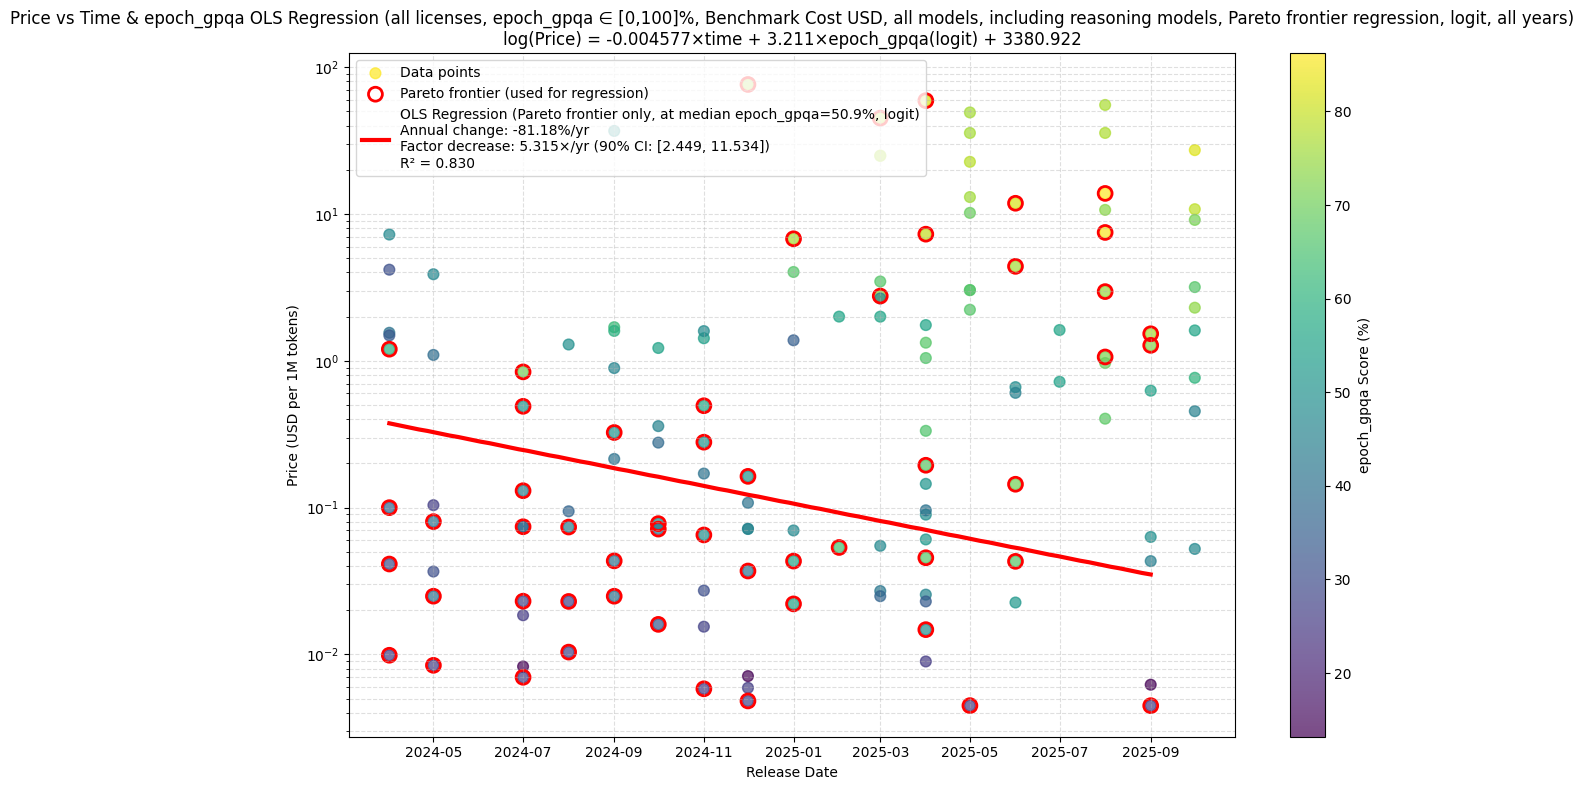


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.004577×time + 3.211×epoch_gpqa(logit) + 3380.922
R² score: 0.8304

Time coefficient (alpha): -0.004577
Annual percentage change: -81.18%/yr
Annual factor decrease: 5.315×/yr
90% CI for factor decrease: [2.449, 11.534]
epoch_gpqa coefficient (beta): 3.211 (logit)
Intercept (c): 3380.922

Data points used for regression: 53
Data points displayed: 138


In [8]:
model, data, results = plot_price_mmlu_regression(
    df_gpqa,
    open_license_only=False,
    price_column="Benchmark Cost USD",
    exclude_dominated=False,
    benchmark_col="epoch_gpqa",
    min_mmlu=0,
    max_mmlu=100,
    exclude_reasoning=False,
    use_huber=False,
    pareto_frontier_only=True,
    use_logit=True,
    year_filter=None,
)

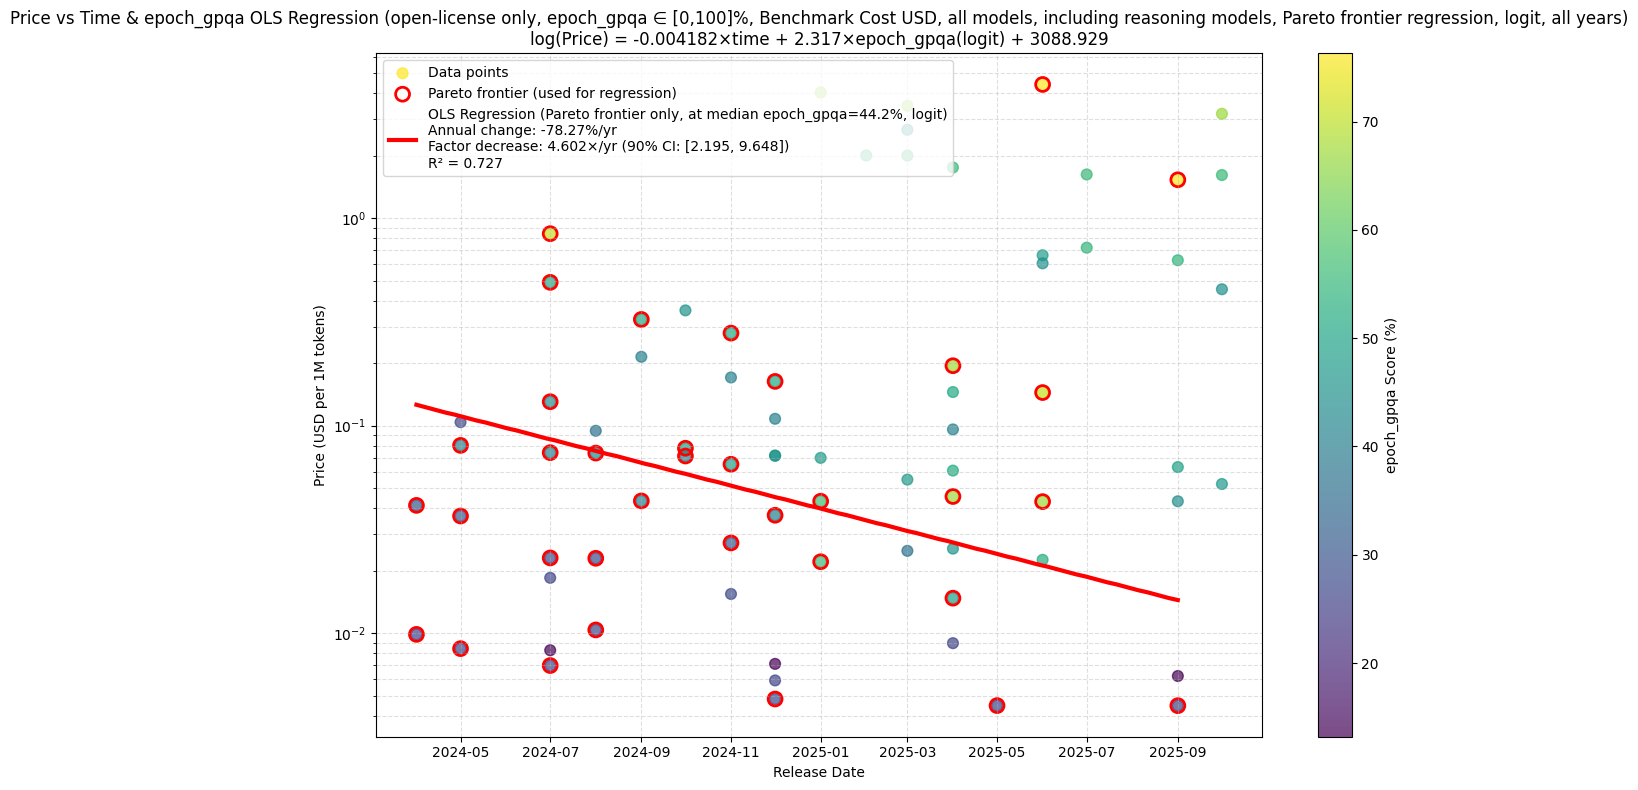


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.004182×time + 2.317×epoch_gpqa(logit) + 3088.929
R² score: 0.7272

Time coefficient (alpha): -0.004182
Annual percentage change: -78.27%/yr
Annual factor decrease: 4.602×/yr
90% CI for factor decrease: [2.195, 9.648]
epoch_gpqa coefficient (beta): 2.317 (logit)
Intercept (c): 3088.929

Data points used for regression: 35
Data points displayed: 75


In [9]:
model, data, results = plot_price_mmlu_regression(
    df_gpqa,
    open_license_only=True,
    price_column="Benchmark Cost USD",
    exclude_dominated=False,
    benchmark_col="epoch_gpqa",
    min_mmlu=0,
    max_mmlu=100,
    exclude_reasoning=False,
    use_huber=False,
    pareto_frontier_only=True,
    use_logit=True,
)

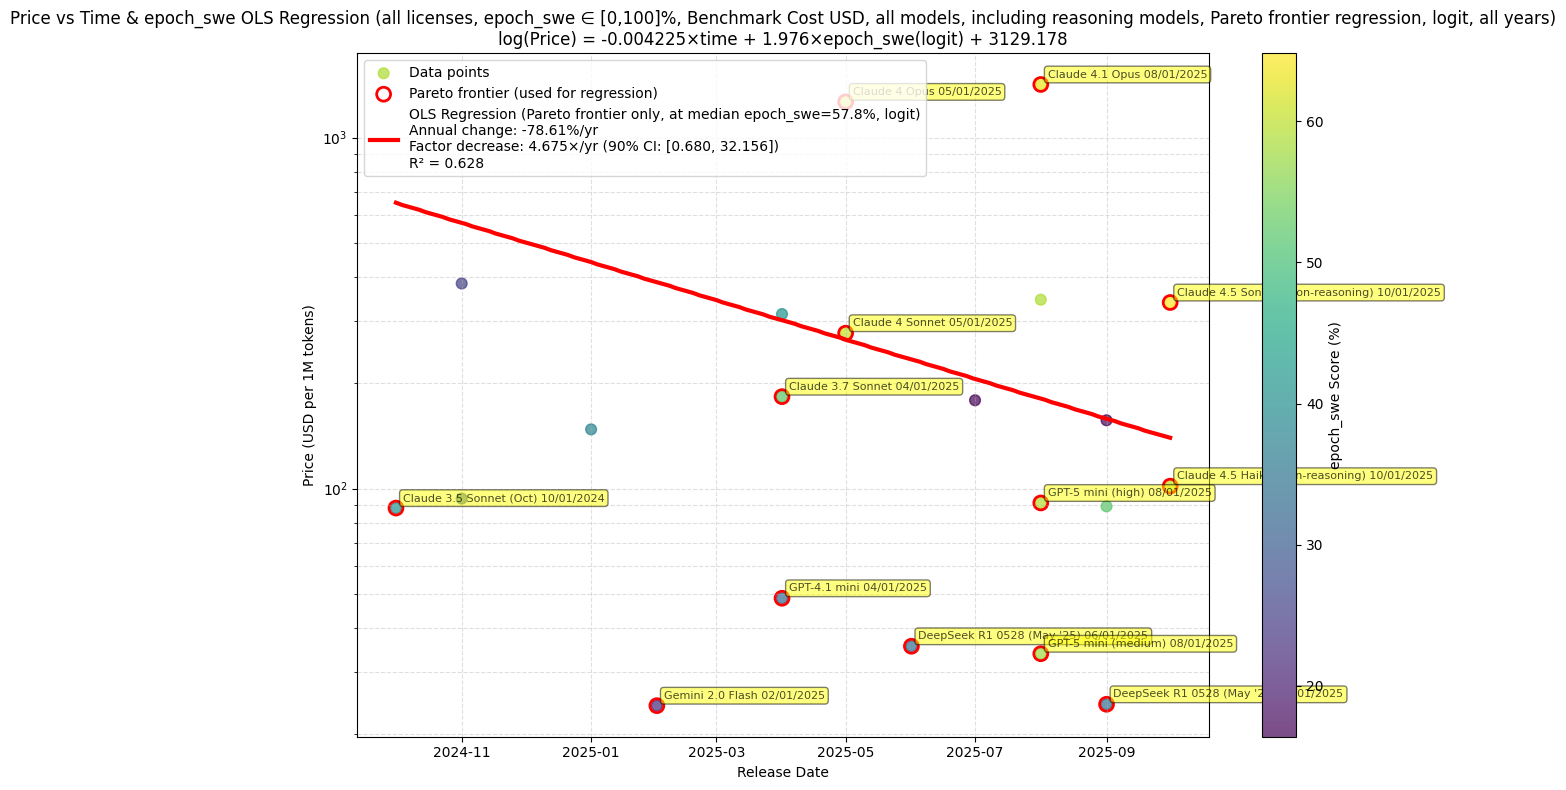


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.004225×time + 1.976×epoch_swe(logit) + 3129.178
R² score: 0.6281

Time coefficient (alpha): -0.004225
Annual percentage change: -78.61%/yr
Annual factor decrease: 4.675×/yr
90% CI for factor decrease: [0.680, 32.156]
epoch_swe coefficient (beta): 1.976 (logit)
Intercept (c): 3129.178

Data points used for regression: 13
Data points displayed: 21


In [10]:

model, data, results = plot_price_mmlu_regression(
    df_swe,
    open_license_only=False,
    price_column="Benchmark Cost USD",
    exclude_dominated=False,
    benchmark_col="epoch_swe",
    min_mmlu=0,
    max_mmlu=100,
    exclude_reasoning=False,
    use_huber=False,
    pareto_frontier_only=True,
    use_logit=True,
    show_model_names=True,
)

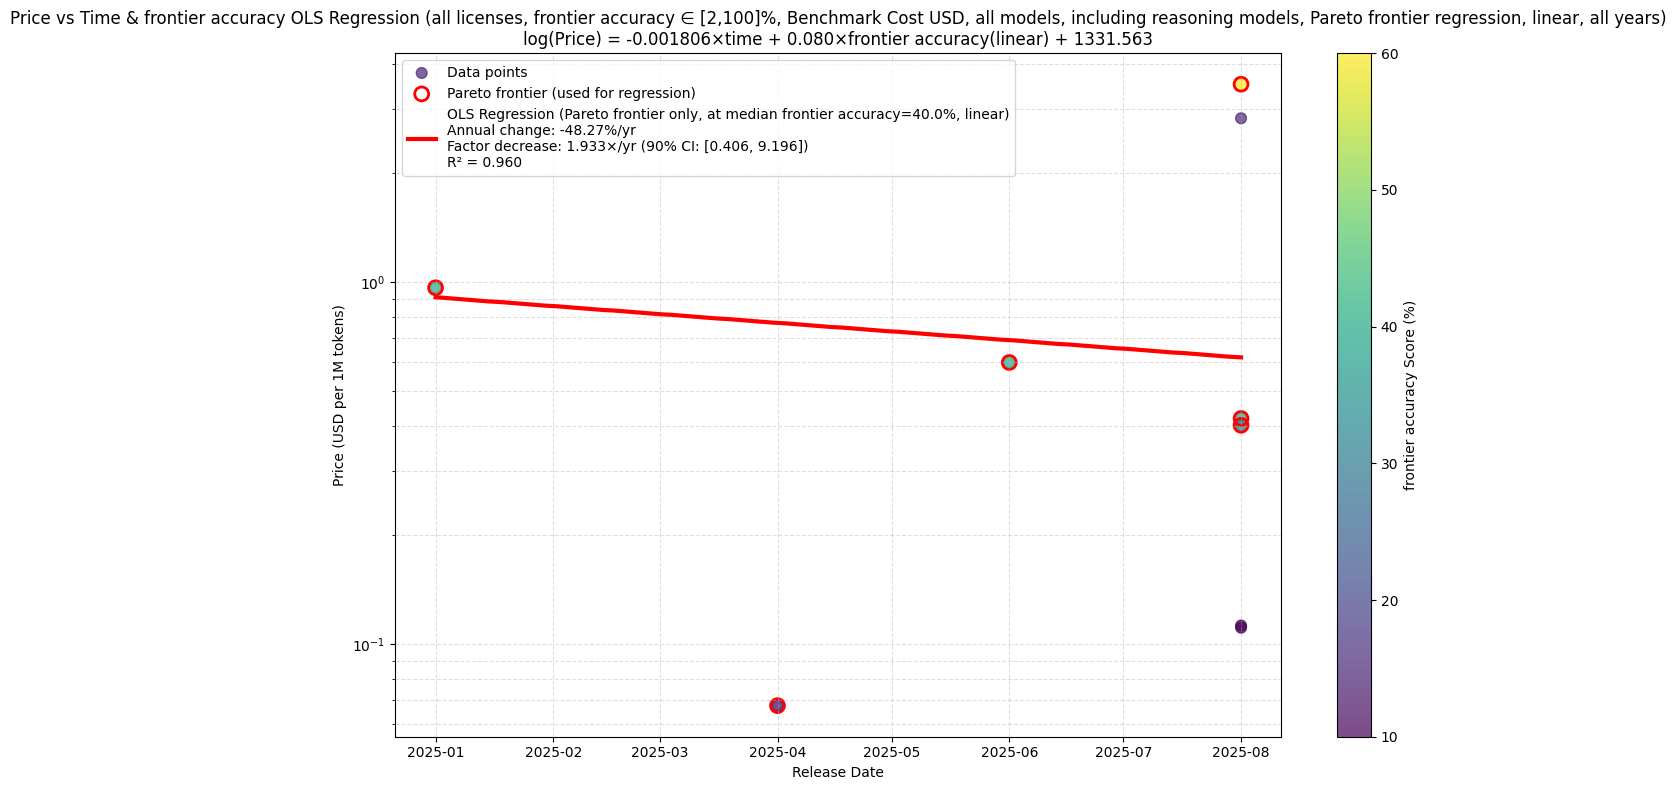


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.001806×time + 0.080×frontier accuracy(linear) + 1331.563
R² score: 0.9603

Time coefficient (alpha): -0.001806
Annual percentage change: -48.27%/yr
Annual factor decrease: 1.933×/yr
90% CI for factor decrease: [0.406, 9.196]
frontier accuracy coefficient (beta): 0.080 (linear)
Intercept (c): 1331.563

Data points used for regression: 6
Data points displayed: 9


In [11]:
# frontier math analysis
model, data, results = plot_price_mmlu_regression(
    df_frontier_math,
    open_license_only=False,
    price_column="Benchmark Cost USD",
    exclude_dominated=False,
    benchmark_col="frontier accuracy",
    min_mmlu=2,
    max_mmlu=100,
    exclude_reasoning=False,
    use_huber=False,
    pareto_frontier_only=True,
)

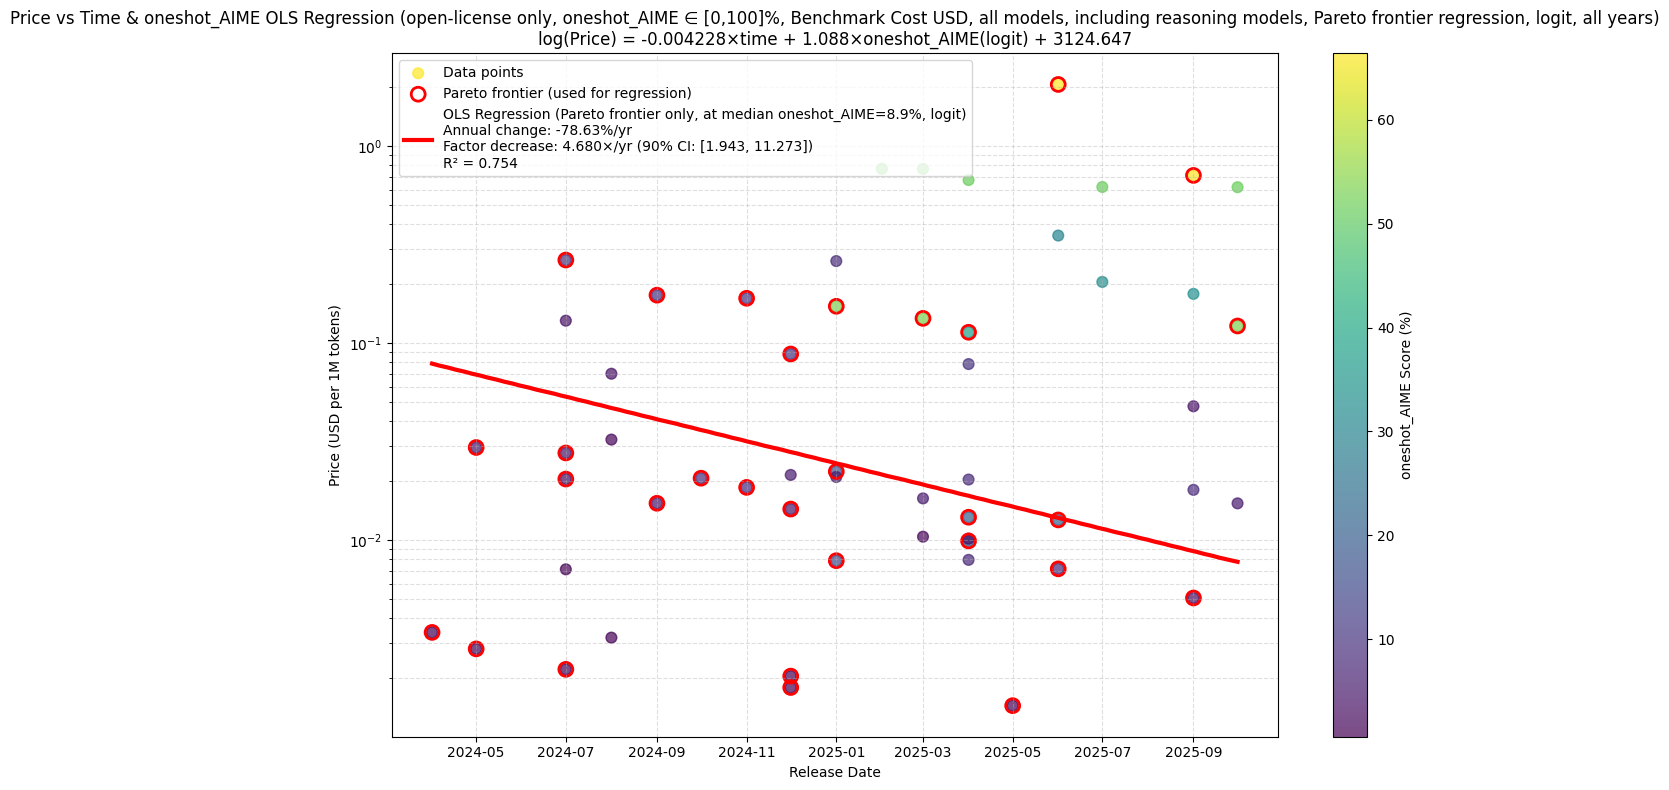


Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.004228×time + 1.088×oneshot_AIME(logit) + 3124.647
R² score: 0.7539

Time coefficient (alpha): -0.004228
Annual percentage change: -78.63%/yr
Annual factor decrease: 4.680×/yr
90% CI for factor decrease: [1.943, 11.273]
oneshot_AIME coefficient (beta): 1.088 (logit)
Intercept (c): 3124.647

Data points used for regression: 30
Data points displayed: 55


In [12]:

model, data, results = plot_price_mmlu_regression(
    df_aime,
    open_license_only=True,
    price_column="Benchmark Cost USD",
    exclude_dominated=False,
    benchmark_col="oneshot_AIME",
    min_mmlu=0,
    max_mmlu=100,
    exclude_reasoning=False,
    use_huber=False,
    pareto_frontier_only=True,
    use_logit=True,
)

In [13]:
# Example usage with logit transformation:
# model, data, results = plot_price_mmlu_regression(
#     df_aime,
#     open_license_only=True,
#     price_column="Benchmark Cost USD",
#     exclude_dominated=False,
#     benchmark_col="oneshot_AIME",
#     min_mmlu=4,
#     max_mmlu=100,
#     exclude_reasoning=False,
#     use_huber=False,
#     pareto_frontier_only=True,
#     use_logit=True,  # Enable logit transformation
# )

In [15]:


# Create comprehensive comparison table
def create_comparison_table(hardware_gain_factor=1.0, year_filter=None):
    """
    Create a table comparing different regression configurations across benchmarks.

    Parameters:
    - hardware_gain_factor: Factor to divide year decrease factors and CIs by (default: 1.0)
                           Use this to adjust for hardware improvements over time
    - year_filter: If specified (e.g., 2024), only include models from that year. If None, no year filtering (default: None)
    """
    # Define configurations
    configurations = [
        {
            "name": "Pareto_restricted_all_license",
            "pareto_frontier_only": True,
            "open_license_only": False,
        },
        {
            "name": "pareto_restricted_open_license",
            "pareto_frontier_only": True,
            "open_license_only": True,
        },
        {
            "name": "all_license_no_restriction",
            "pareto_frontier_only": False,
            "open_license_only": False,
        },
        {
            "name": "open_license_only_no_restriction",
            "pareto_frontier_only": False,
            "open_license_only": True,
        },
    ]

    # Define benchmarks with their configurations
    benchmarks = [
        {
            "name": "GPQA",
            "df": df_gpqa,
            "benchmark_col": "epoch_gpqa",
            "min_mmlu": 0,
            "max_mmlu": 100,
            "use_logit": True,
        },
        {
            "name": "AIME",
            "df": df_aime,
            "benchmark_col": "oneshot_AIME",
            "min_mmlu": 0,
            "max_mmlu": 100,
            "use_logit": True,
        },
        {
            "name": "SWE-Bench",
            "df": df_swe,
            "benchmark_col": "epoch_swe",
            "min_mmlu": 0,
            "max_mmlu": 100,
            "use_logit": True,
        },
    ]

    # Collect results
    results_data = []

    for benchmark in benchmarks:
        for config in configurations:
            print(f"\nProcessing {benchmark['name']} - {config['name']}...")

            # Run regression without showing plot
            model, data, results = plot_price_mmlu_regression(
                df=benchmark["df"],
                open_license_only=config["open_license_only"],
                price_column="Benchmark Cost USD",
                exclude_dominated=False,
                benchmark_col=benchmark["benchmark_col"],
                min_mmlu=benchmark["min_mmlu"],
                max_mmlu=benchmark["max_mmlu"],
                exclude_reasoning=False,
                use_huber=False,
                pareto_frontier_only=config["pareto_frontier_only"],
                use_logit=benchmark["use_logit"],
                show_plot=False,  # Don't show plots for table generation
                year_filter=year_filter,  # Pass year filter parameter
            )

            # Extract results if regression was successful
            if results is not None:
                factor_decrease = results["factor_decrease_per_year"]
                ci_lower = results["factor_decrease_ci_lower"]
                ci_upper = results["factor_decrease_ci_upper"]
                r2 = results["r2_score"]
                n = len(data) if data is not None else 0

                # Apply hardware gain factor adjustment
                factor_decrease_adjusted = factor_decrease / hardware_gain_factor

                # Format CI string with hardware gain factor adjustment
                if ci_lower is not None and ci_upper is not None:
                    ci_lower_adjusted = ci_lower / hardware_gain_factor
                    ci_upper_adjusted = ci_upper / hardware_gain_factor
                    ci_str = f"[{ci_lower_adjusted:.3f}, {ci_upper_adjusted:.3f}]"
                else:
                    ci_str = "N/A"

                results_data.append(
                    {
                        "Benchmark": benchmark["name"],
                        "Configuration": config["name"],
                        "Annual Factor Decrease": f"{factor_decrease_adjusted:.3f}",
                        "90% CI": ci_str,
                        "n": n,
                        "R²": f"{r2:.4f}",
                    }
                )
            else:
                # If regression failed, add placeholder
                results_data.append(
                    {
                        "Benchmark": benchmark["name"],
                        "Configuration": config["name"],
                        "Annual Factor Decrease": "N/A",
                        "90% CI": "N/A",
                        "n": 0,
                        "R²": "N/A",
                    }
                )

    # Create DataFrame with long format (benchmark sections with multiple rows)
    results_df = pd.DataFrame(results_data)

    # Reorder to match desired format
    results_df = results_df[
        ["Benchmark", "Configuration", "Annual Factor Decrease", "90% CI", "n", "R²"]
    ]

    # Rename columns to match table headers
    results_df.columns = [
        "Benchmark",
        "Restriction",
        "Year Decrease Factor",
        "90% CI",
        "n",
        "R²",
    ]

    # Reorder rows: group by benchmark, with configurations in the desired order
    benchmark_order = ["GPQA", "AIME", "SWE-Bench"]
    config_order = [
        "Pareto_restricted_all_license",
        "pareto_restricted_open_license",
        "all_license_no_restriction",
        "open_license_only_no_restriction",
    ]

    # Create ordered dataframe
    ordered_rows = []
    for benchmark in benchmark_order:
        for config in config_order:
            row = results_df[
                (results_df["Benchmark"] == benchmark)
                & (results_df["Restriction"] == config)
            ]
            if not row.empty:
                ordered_rows.append(row)

    results_df = pd.concat(ordered_rows, ignore_index=True)

    # Clean up restriction names to match your format
    restriction_mapping = {
        "Pareto_restricted_all_license": "Pareto Restricted All License",
        "pareto_restricted_open_license": "Pareto Restricted Open License",
        "all_license_no_restriction": "All License (no restriction)",
        "open_license_only_no_restriction": "Open License (no restriction)",
    }
    results_df["Restriction"] = results_df["Restriction"].map(restriction_mapping)

    # For each benchmark group, only show benchmark name in first row
    for i in range(1, len(results_df)):
        if results_df.loc[i, "Benchmark"] == results_df.loc[i - 1, "Benchmark"]:
            results_df.loc[i, "Benchmark"] = ""

    return results_df


# Generate and display the table
print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON TABLE")
print("=" * 80 + "\n")
# Set hardware_gain_factor to adjust for hardware improvements (default is 1.0, no adjustment)
# For example, hardware_gain_factor=2.0 would divide all year decrease factors by 2
comparison_table = create_comparison_table(hardware_gain_factor=(1 / 0.7))
print("\n")
print(comparison_table.to_string(index=False))
print("\n")

# Save to CSV
comparison_table.to_csv("regression_comparison_table.csv", index=False)
print("Table saved to 'regression_comparison_table.csv'")

# Save to LaTeX
latex_table = comparison_table.to_latex(
    index=False,
    escape=False,
    column_format="|l|l|c|c|c|c|",
    caption="Regression Results Across Benchmarks and Restrictions",
    label="tab:regression_results_restructured",
)
with open("regression_comparison_table.tex", "w") as f:
    f.write(latex_table)
print("LaTeX table saved to 'regression_comparison_table.tex'")


COMPREHENSIVE COMPARISON TABLE


Processing GPQA - Pareto_restricted_all_license...

Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.004577×time + 3.211×epoch_gpqa(logit) + 3380.922
R² score: 0.8304

Time coefficient (alpha): -0.004577
Annual percentage change: -81.18%/yr
Annual factor decrease: 5.315×/yr
90% CI for factor decrease: [2.449, 11.534]
epoch_gpqa coefficient (beta): 3.211 (logit)
Intercept (c): 3380.922

Data points used for regression: 53
Data points displayed: 138

Processing GPQA - pareto_restricted_open_license...

Regression Results (OLS):
Data used: Pareto frontier only
Model: log(Price) = -0.004182×time + 2.317×epoch_gpqa(logit) + 3088.929
R² score: 0.7272

Time coefficient (alpha): -0.004182
Annual percentage change: -78.27%/yr
Annual factor decrease: 4.602×/yr
90% CI for factor decrease: [2.195, 9.648]
epoch_gpqa coefficient (beta): 2.317 (logit)
Intercept (c): 3088.929

Data points used for regression: 35
Data points displayed: 7

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_36127/2239451897.py:269: RuntimeWarning: divide by zero encountered in scalar divide
  mse = np.sum(residuals**2) / (n - p - 1)
